## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 필요한 라이브러리를 설치합니다.
!pip install timm
!pip install matplotlib
!pip install seaborn
!pip install optuna
!apt install -y libgl1-mesa-glx
!pip install albumentations

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libexpat1 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libllvm12 libpciaccess0 libsensors-config libsensors5
  libvulkan1 libwayland-client0 libx11-6 libx11-data libx11-xcb1 libxau6
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0
  libxcb-shm0 libxcb-sync1 libxcb-xfixes0 libxcb1 libxdmcp6 libxext6
  libxfixes3 libxshmfence1 libxxf86vm1 mesa-vulkan-drivers
Suggested packages:
  pciutils lm-sensors
The following NEW packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libexpat1 libgl1 libgl1-mesa-dri libgl1-mesa-glx
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libllvm12 libpciaccess0
  libsensors-config libsensors5 libvulkan1 libwa

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_large_384_in22ft1k'
# model_name = 'convnextv2_base.fcmae_ft_in22k_in1k_384'
# model_name = 'vit_base_patch16_clip_384.laion2b_ft_in12k_in1k' # openclip
# model_name = 'vit_base_patch16_384.augreg_in1k' # augreg
# model_name = 'eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k' # eva-02 멀티모달
# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용
# model_name = 'vit_base_patch14_reg4_dinov2.lvd142m' # dinov2 reg4

# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용

# training config
img_size = 512
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 10
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [10]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

Val Loss: 0.7243: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]

Epoch  1 | Train Loss: 1.5547 | Train F1: 0.5221 | Val Loss: 0.7919 | Val F1: 0.7882



Val Loss: 0.8532: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]

Epoch  2 | Train Loss: 0.8982 | Train F1: 0.7196 | Val Loss: 0.6148 | Val F1: 0.8715



Val Loss: 1.2745: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch  3 | Train Loss: 0.8015 | Train F1: 0.7371 | Val Loss: 0.6201 | Val F1: 0.8557


Val Loss: 0.5664: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

Epoch  4 | Train Loss: 0.7792 | Train F1: 0.7954 | Val Loss: 0.5511 | Val F1: 0.9152



Val Loss: 0.3768: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch  5 | Train Loss: 0.7782 | Train F1: 0.7726 | Val Loss: 0.5957 | Val F1: 0.8978


Val Loss: 0.3475: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch  6 | Train Loss: 0.7169 | Train F1: 0.7739 | Val Loss: 0.6442 | Val F1: 0.8887


Val Loss: 0.7987: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch  7 | Train Loss: 0.6426 | Train F1: 0.8368 | Val Loss: 0.4849 | Val F1: 0.9494



Val Loss: 0.6170: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch  8 | Train Loss: 0.5951 | Train F1: 0.8698 | Val Loss: 0.5035 | Val F1: 0.9351


Val Loss: 0.3475: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch  9 | Train Loss: 0.6286 | Train F1: 0.8275 | Val Loss: 0.5332 | Val F1: 0.9309


Val Loss: 0.6853: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 10 | Train Loss: 0.7050 | Train F1: 0.8226 | Val Loss: 0.6172 | Val F1: 0.8807


Val Loss: 0.3526: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 11 | Train Loss: 0.6417 | Train F1: 0.8259 | Val Loss: 0.4994 | Val F1: 0.9485


Val Loss: 0.3331: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 12 | Train Loss: 0.6191 | Train F1: 0.8382 | Val Loss: 0.5446 | Val F1: 0.9264


Val Loss: 0.3349: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 13 | Train Loss: 0.5777 | Train F1: 0.8540 | Val Loss: 0.4925 | Val F1: 0.9374


Val Loss: 1.1098: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

Epoch 14 | Train Loss: 0.5507 | Train F1: 0.8677 | Val Loss: 0.4658 | Val F1: 0.9523



Val Loss: 0.3659: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 15 | Train Loss: 0.6024 | Train F1: 0.8157 | Val Loss: 0.5358 | Val F1: 0.9056


Val Loss: 0.4936: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 16 | Train Loss: 0.5836 | Train F1: 0.8690 | Val Loss: 0.4468 | Val F1: 0.9534



Val Loss: 0.3392: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 17 | Train Loss: 0.6398 | Train F1: 0.8579 | Val Loss: 0.5625 | Val F1: 0.9325


Val Loss: 0.3685: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 18 | Train Loss: 0.5985 | Train F1: 0.8340 | Val Loss: 0.4532 | Val F1: 0.9546



Val Loss: 0.3285: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 19 | Train Loss: 0.5350 | Train F1: 0.8656 | Val Loss: 0.4420 | Val F1: 0.9688



Val Loss: 0.3644: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 20 | Train Loss: 0.5640 | Train F1: 0.8755 | Val Loss: 0.4898 | Val F1: 0.9445


Val Loss: 0.3901: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 21 | Train Loss: 0.5877 | Train F1: 0.8439 | Val Loss: 0.4478 | Val F1: 0.9640


Val Loss: 1.2040: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 22 | Train Loss: 0.5609 | Train F1: 0.8680 | Val Loss: 0.4676 | Val F1: 0.9623


Val Loss: 0.3301: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

Epoch 23 | Train Loss: 0.6381 | Train F1: 0.8411 | Val Loss: 0.4389 | Val F1: 0.9690



Val Loss: 0.4017: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 24 | Train Loss: 0.5848 | Train F1: 0.8348 | Val Loss: 0.4137 | Val F1: 0.9714



Val Loss: 0.3301: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 25 | Train Loss: 0.5670 | Train F1: 0.8796 | Val Loss: 0.4259 | Val F1: 0.9633


Val Loss: 1.2656: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 26 | Train Loss: 0.6234 | Train F1: 0.8514 | Val Loss: 0.4922 | Val F1: 0.9543


Val Loss: 0.3217: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 27 | Train Loss: 0.6247 | Train F1: 0.8309 | Val Loss: 0.4507 | Val F1: 0.9608


Val Loss: 0.4967: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 28 | Train Loss: 0.5719 | Train F1: 0.8605 | Val Loss: 0.4471 | Val F1: 0.9658


Val Loss: 0.3242: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 29 | Train Loss: 0.5019 | Train F1: 0.8978 | Val Loss: 0.4596 | Val F1: 0.9625


Val Loss: 0.4787: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 30 | Train Loss: 0.5368 | Train F1: 0.8540 | Val Loss: 0.4804 | Val F1: 0.9597


Val Loss: 0.4707: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 31 | Train Loss: 0.5278 | Train F1: 0.8878 | Val Loss: 0.4468 | Val F1: 0.9624


Val Loss: 0.3275: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 32 | Train Loss: 0.5588 | Train F1: 0.8656 | Val Loss: 0.4445 | Val F1: 0.9677


Val Loss: 0.3331: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 33 | Train Loss: 0.5640 | Train F1: 0.8502 | Val Loss: 0.4621 | Val F1: 0.9656


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 34 | Train Loss: 0.5852 | Train F1: 0.8486 | Val Loss: 0.4483 | Val F1: 0.9662


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 35 | Train Loss: 0.5559 | Train F1: 0.8857 | Val Loss: 0.4654 | Val F1: 0.9647


Val Loss: 0.3222: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 36 | Train Loss: 0.5743 | Train F1: 0.8381 | Val Loss: 0.4705 | Val F1: 0.9634


Val Loss: 0.3295: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 37 | Train Loss: 0.5240 | Train F1: 0.8681 | Val Loss: 0.4234 | Val F1: 0.9685


Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 38 | Train Loss: 0.5644 | Train F1: 0.8477 | Val Loss: 0.4385 | Val F1: 0.9687


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 39 | Train Loss: 0.4739 | Train F1: 0.8888 | Val Loss: 0.4285 | Val F1: 0.9729



Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 40 | Train Loss: 0.5404 | Train F1: 0.8497 | Val Loss: 0.4384 | Val F1: 0.9676


Val Loss: 0.3231: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 41 | Train Loss: 0.5399 | Train F1: 0.8857 | Val Loss: 0.5133 | Val F1: 0.9479


Val Loss: 0.3302: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 42 | Train Loss: 0.5154 | Train F1: 0.8784 | Val Loss: 0.4783 | Val F1: 0.9599


Val Loss: 0.3214: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 43 | Train Loss: 0.5378 | Train F1: 0.8656 | Val Loss: 0.4460 | Val F1: 0.9635


Val Loss: 0.3240: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 44 | Train Loss: 0.5223 | Train F1: 0.8602 | Val Loss: 0.4575 | Val F1: 0.9540


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 45 | Train Loss: 0.4973 | Train F1: 0.8537 | Val Loss: 0.4309 | Val F1: 0.9706


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 46 | Train Loss: 0.5128 | Train F1: 0.8880 | Val Loss: 0.4700 | Val F1: 0.9631


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 47 | Train Loss: 0.5438 | Train F1: 0.8876 | Val Loss: 0.4605 | Val F1: 0.9661


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 48 | Train Loss: 0.5162 | Train F1: 0.8863 | Val Loss: 0.4524 | Val F1: 0.9650


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 49 | Train Loss: 0.5844 | Train F1: 0.8302 | Val Loss: 0.4691 | Val F1: 0.9629


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 50 | Train Loss: 0.4930 | Train F1: 0.8753 | Val Loss: 0.4617 | Val F1: 0.9662


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 51 | Train Loss: 0.4843 | Train F1: 0.8990 | Val Loss: 0.4442 | Val F1: 0.9685


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 52 | Train Loss: 0.4946 | Train F1: 0.8836 | Val Loss: 0.4343 | Val F1: 0.9715


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 53 | Train Loss: 0.4932 | Train F1: 0.8316 | Val Loss: 0.4394 | Val F1: 0.9685


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 54 | Train Loss: 0.5170 | Train F1: 0.8671 | Val Loss: 0.4477 | Val F1: 0.9690


Val Loss: 0.3237: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 55 | Train Loss: 0.5436 | Train F1: 0.8714 | Val Loss: 0.4500 | Val F1: 0.9657


Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 56 | Train Loss: 0.5096 | Train F1: 0.8906 | Val Loss: 0.4347 | Val F1: 0.9657


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 57 | Train Loss: 0.4835 | Train F1: 0.8467 | Val Loss: 0.4361 | Val F1: 0.9715


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 58 | Train Loss: 0.4942 | Train F1: 0.8948 | Val Loss: 0.4476 | Val F1: 0.9687


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 59 | Train Loss: 0.5317 | Train F1: 0.8599 | Val Loss: 0.4441 | Val F1: 0.9659


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 60 | Train Loss: 0.5008 | Train F1: 0.8491 | Val Loss: 0.4449 | Val F1: 0.9690


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 61 | Train Loss: 0.4732 | Train F1: 0.8714 | Val Loss: 0.4613 | Val F1: 0.9660


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 62 | Train Loss: 0.5262 | Train F1: 0.8491 | Val Loss: 0.4590 | Val F1: 0.9704


Val Loss: 0.3250: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 63 | Train Loss: 0.5455 | Train F1: 0.8368 | Val Loss: 0.4783 | Val F1: 0.9630


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 64 | Train Loss: 0.4987 | Train F1: 0.8654 | Val Loss: 0.4564 | Val F1: 0.9690


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 65 | Train Loss: 0.4906 | Train F1: 0.8995 | Val Loss: 0.4783 | Val F1: 0.9632


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 66 | Train Loss: 0.5052 | Train F1: 0.8699 | Val Loss: 0.4444 | Val F1: 0.9715


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 67 | Train Loss: 0.5187 | Train F1: 0.8676 | Val Loss: 0.4646 | Val F1: 0.9635


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 68 | Train Loss: 0.4715 | Train F1: 0.8590 | Val Loss: 0.5001 | Val F1: 0.9576


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 69 | Train Loss: 0.5043 | Train F1: 0.8776 | Val Loss: 0.4558 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 70 | Train Loss: 0.5185 | Train F1: 0.8479 | Val Loss: 0.4413 | Val F1: 0.9656


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 71 | Train Loss: 0.4999 | Train F1: 0.8596 | Val Loss: 0.4508 | Val F1: 0.9653


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 72 | Train Loss: 0.4992 | Train F1: 0.8567 | Val Loss: 0.4398 | Val F1: 0.9717


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 73 | Train Loss: 0.4924 | Train F1: 0.8849 | Val Loss: 0.4408 | Val F1: 0.9717


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 74 | Train Loss: 0.4828 | Train F1: 0.8747 | Val Loss: 0.4417 | Val F1: 0.9715


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 75 | Train Loss: 0.4791 | Train F1: 0.8784 | Val Loss: 0.4413 | Val F1: 0.9715


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 76 | Train Loss: 0.5420 | Train F1: 0.7859 | Val Loss: 0.4567 | Val F1: 0.9687


Val Loss: 0.3212: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 77 | Train Loss: 0.4830 | Train F1: 0.8927 | Val Loss: 0.4415 | Val F1: 0.9715


Val Loss: 0.3412: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 78 | Train Loss: 0.4921 | Train F1: 0.8284 | Val Loss: 0.4469 | Val F1: 0.9685


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 79 | Train Loss: 0.4616 | Train F1: 0.8903 | Val Loss: 0.4555 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 80 | Train Loss: 0.5098 | Train F1: 0.8387 | Val Loss: 0.4382 | Val F1: 0.9657


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 81 | Train Loss: 0.4963 | Train F1: 0.8848 | Val Loss: 0.4476 | Val F1: 0.9690


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 82 | Train Loss: 0.4680 | Train F1: 0.8883 | Val Loss: 0.4665 | Val F1: 0.9638


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 83 | Train Loss: 0.5282 | Train F1: 0.8476 | Val Loss: 0.4488 | Val F1: 0.9699


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 84 | Train Loss: 0.5393 | Train F1: 0.8387 | Val Loss: 0.4419 | Val F1: 0.9687


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 85 | Train Loss: 0.4896 | Train F1: 0.8659 | Val Loss: 0.4578 | Val F1: 0.9699


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 86 | Train Loss: 0.4790 | Train F1: 0.9119 | Val Loss: 0.4390 | Val F1: 0.9715


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 87 | Train Loss: 0.4973 | Train F1: 0.8781 | Val Loss: 0.4288 | Val F1: 0.9713


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 88 | Train Loss: 0.4701 | Train F1: 0.8827 | Val Loss: 0.4442 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 89 | Train Loss: 0.4798 | Train F1: 0.8915 | Val Loss: 0.4566 | Val F1: 0.9687


Val Loss: 0.3222: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 90 | Train Loss: 0.4774 | Train F1: 0.8741 | Val Loss: 0.4306 | Val F1: 0.9715


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 91 | Train Loss: 0.5064 | Train F1: 0.8419 | Val Loss: 0.4511 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 92 | Train Loss: 0.4966 | Train F1: 0.8520 | Val Loss: 0.4527 | Val F1: 0.9685


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 93 | Train Loss: 0.4805 | Train F1: 0.9206 | Val Loss: 0.4564 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 94 | Train Loss: 0.4948 | Train F1: 0.9086 | Val Loss: 0.4530 | Val F1: 0.9690


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 95 | Train Loss: 0.4804 | Train F1: 0.8652 | Val Loss: 0.4565 | Val F1: 0.9699


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch 96 | Train Loss: 0.4599 | Train F1: 0.9190 | Val Loss: 0.4319 | Val F1: 0.9729



Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 97 | Train Loss: 0.4529 | Train F1: 0.8956 | Val Loss: 0.4509 | Val F1: 0.9687


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 98 | Train Loss: 0.4699 | Train F1: 0.8700 | Val Loss: 0.4413 | Val F1: 0.9715


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 99 | Train Loss: 0.5085 | Train F1: 0.8529 | Val Loss: 0.4403 | Val F1: 0.9717


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 100 | Train Loss: 0.4615 | Train F1: 0.8876 | Val Loss: 0.4433 | Val F1: 0.9715
Fold 1 Best Validation F1: 0.9729

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.8652: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  1 | Train Loss: 1.6303 | Train F1: 0.4864 | Val Loss: 0.7544 | Val F1: 0.7903



Val Loss: 0.4618: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  2 | Train Loss: 1.0215 | Train F1: 0.6740 | Val Loss: 0.6260 | Val F1: 0.8631



Val Loss: 0.4830: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch  3 | Train Loss: 0.8464 | Train F1: 0.7507 | Val Loss: 0.5802 | Val F1: 0.8750



Val Loss: 1.0467: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch  4 | Train Loss: 0.7523 | Train F1: 0.7545 | Val Loss: 0.5885 | Val F1: 0.8591


Val Loss: 0.3813: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch  5 | Train Loss: 0.6494 | Train F1: 0.8544 | Val Loss: 0.5228 | Val F1: 0.9143



Val Loss: 0.5556: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch  6 | Train Loss: 0.8202 | Train F1: 0.7836 | Val Loss: 0.5157 | Val F1: 0.9218



Val Loss: 0.4730: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  7 | Train Loss: 0.6679 | Train F1: 0.8377 | Val Loss: 0.4460 | Val F1: 0.9427



Val Loss: 0.5417: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  8 | Train Loss: 0.7248 | Train F1: 0.7987 | Val Loss: 0.6115 | Val F1: 0.8791


Val Loss: 0.4012: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch  9 | Train Loss: 0.7467 | Train F1: 0.8233 | Val Loss: 0.4695 | Val F1: 0.9405


Val Loss: 0.4171: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 10 | Train Loss: 0.6164 | Train F1: 0.8345 | Val Loss: 0.4509 | Val F1: 0.9495



Val Loss: 0.3391: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 11 | Train Loss: 0.6657 | Train F1: 0.7803 | Val Loss: 0.4850 | Val F1: 0.9492


Val Loss: 0.3942: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 12 | Train Loss: 0.5783 | Train F1: 0.8590 | Val Loss: 0.4398 | Val F1: 0.9586



Val Loss: 0.3849: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 13 | Train Loss: 0.6481 | Train F1: 0.8553 | Val Loss: 0.5234 | Val F1: 0.9378


Val Loss: 0.3632: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 14 | Train Loss: 0.6006 | Train F1: 0.8240 | Val Loss: 0.4064 | Val F1: 0.9778



Val Loss: 0.3288: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 15 | Train Loss: 0.6093 | Train F1: 0.8641 | Val Loss: 0.4259 | Val F1: 0.9751


Val Loss: 0.3345: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 16 | Train Loss: 0.6128 | Train F1: 0.8113 | Val Loss: 0.4415 | Val F1: 0.9566


Val Loss: 0.3355: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 17 | Train Loss: 0.6461 | Train F1: 0.8245 | Val Loss: 0.4239 | Val F1: 0.9624


Val Loss: 0.3720: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 18 | Train Loss: 0.5720 | Train F1: 0.8462 | Val Loss: 0.4527 | Val F1: 0.9489


Val Loss: 0.3366: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 19 | Train Loss: 0.5383 | Train F1: 0.8651 | Val Loss: 0.4205 | Val F1: 0.9699


Val Loss: 0.3257: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 20 | Train Loss: 0.5601 | Train F1: 0.8515 | Val Loss: 0.4346 | Val F1: 0.9713


Val Loss: 0.3369: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 21 | Train Loss: 0.5213 | Train F1: 0.9054 | Val Loss: 0.4161 | Val F1: 0.9760


Val Loss: 0.3285: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 22 | Train Loss: 0.5256 | Train F1: 0.8805 | Val Loss: 0.4168 | Val F1: 0.9692


Val Loss: 0.3389: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 23 | Train Loss: 0.5318 | Train F1: 0.8326 | Val Loss: 0.4258 | Val F1: 0.9725


Val Loss: 0.3241: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 24 | Train Loss: 0.5824 | Train F1: 0.8411 | Val Loss: 0.4510 | Val F1: 0.9674


Val Loss: 0.3433: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 25 | Train Loss: 0.5820 | Train F1: 0.8472 | Val Loss: 0.3932 | Val F1: 0.9775


Val Loss: 0.3225: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 26 | Train Loss: 0.6086 | Train F1: 0.7941 | Val Loss: 0.4225 | Val F1: 0.9673


Val Loss: 0.3262: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 27 | Train Loss: 0.5603 | Train F1: 0.8433 | Val Loss: 0.4012 | Val F1: 0.9736


Val Loss: 0.3234: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 28 | Train Loss: 0.5519 | Train F1: 0.8584 | Val Loss: 0.4023 | Val F1: 0.9753


Val Loss: 0.3236: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 29 | Train Loss: 0.5563 | Train F1: 0.8304 | Val Loss: 0.4006 | Val F1: 0.9796



Val Loss: 0.3806: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 30 | Train Loss: 0.5298 | Train F1: 0.8893 | Val Loss: 0.3993 | Val F1: 0.9789


Val Loss: 0.3235: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 31 | Train Loss: 0.5024 | Train F1: 0.8922 | Val Loss: 0.4356 | Val F1: 0.9690


Val Loss: 0.3291: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 32 | Train Loss: 0.5290 | Train F1: 0.8567 | Val Loss: 0.4306 | Val F1: 0.9657


Val Loss: 0.3223: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 33 | Train Loss: 0.5120 | Train F1: 0.8809 | Val Loss: 0.3809 | Val F1: 0.9834



Val Loss: 0.3290: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 34 | Train Loss: 0.5821 | Train F1: 0.8668 | Val Loss: 0.4620 | Val F1: 0.9476


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 35 | Train Loss: 0.5776 | Train F1: 0.8798 | Val Loss: 0.4151 | Val F1: 0.9766


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 36 | Train Loss: 0.5444 | Train F1: 0.8734 | Val Loss: 0.4170 | Val F1: 0.9764


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 37 | Train Loss: 0.5554 | Train F1: 0.8616 | Val Loss: 0.4223 | Val F1: 0.9578


Val Loss: 0.3225: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 38 | Train Loss: 0.5723 | Train F1: 0.8342 | Val Loss: 0.4084 | Val F1: 0.9683


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 39 | Train Loss: 0.5345 | Train F1: 0.8859 | Val Loss: 0.3964 | Val F1: 0.9804


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 40 | Train Loss: 0.5174 | Train F1: 0.8851 | Val Loss: 0.3905 | Val F1: 0.9763


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 41 | Train Loss: 0.5029 | Train F1: 0.9051 | Val Loss: 0.4694 | Val F1: 0.9557


Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 42 | Train Loss: 0.5161 | Train F1: 0.8685 | Val Loss: 0.4369 | Val F1: 0.9695


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 43 | Train Loss: 0.5001 | Train F1: 0.8724 | Val Loss: 0.4084 | Val F1: 0.9746


Val Loss: 0.3239: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 44 | Train Loss: 0.5243 | Train F1: 0.8620 | Val Loss: 0.3853 | Val F1: 0.9782


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 45 | Train Loss: 0.4854 | Train F1: 0.8683 | Val Loss: 0.4115 | Val F1: 0.9732


Val Loss: 0.3215: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 46 | Train Loss: 0.5455 | Train F1: 0.8568 | Val Loss: 0.4053 | Val F1: 0.9751


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 47 | Train Loss: 0.4865 | Train F1: 0.9034 | Val Loss: 0.4103 | Val F1: 0.9667


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 48 | Train Loss: 0.5074 | Train F1: 0.8824 | Val Loss: 0.4118 | Val F1: 0.9804


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 49 | Train Loss: 0.4837 | Train F1: 0.8669 | Val Loss: 0.4539 | Val F1: 0.9716


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 50 | Train Loss: 0.4911 | Train F1: 0.9040 | Val Loss: 0.4068 | Val F1: 0.9778


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 51 | Train Loss: 0.5062 | Train F1: 0.8912 | Val Loss: 0.3978 | Val F1: 0.9804


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 52 | Train Loss: 0.5325 | Train F1: 0.8594 | Val Loss: 0.4051 | Val F1: 0.9745


Val Loss: 0.3212: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 53 | Train Loss: 0.5655 | Train F1: 0.7991 | Val Loss: 0.3870 | Val F1: 0.9834


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 54 | Train Loss: 0.5677 | Train F1: 0.8530 | Val Loss: 0.4015 | Val F1: 0.9756


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 55 | Train Loss: 0.5226 | Train F1: 0.8379 | Val Loss: 0.4141 | Val F1: 0.9745


Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch 56 | Train Loss: 0.4926 | Train F1: 0.8689 | Val Loss: 0.3718 | Val F1: 0.9866



Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 57 | Train Loss: 0.4925 | Train F1: 0.8781 | Val Loss: 0.3807 | Val F1: 0.9824


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 58 | Train Loss: 0.4938 | Train F1: 0.8993 | Val Loss: 0.3832 | Val F1: 0.9783


Val Loss: 0.3224: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 59 | Train Loss: 0.5407 | Train F1: 0.8307 | Val Loss: 0.4054 | Val F1: 0.9773


Val Loss: 0.3548: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 60 | Train Loss: 0.5194 | Train F1: 0.8515 | Val Loss: 0.4007 | Val F1: 0.9751


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 61 | Train Loss: 0.5460 | Train F1: 0.8779 | Val Loss: 0.4070 | Val F1: 0.9793


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 62 | Train Loss: 0.4814 | Train F1: 0.8646 | Val Loss: 0.3986 | Val F1: 0.9806


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 63 | Train Loss: 0.5427 | Train F1: 0.8699 | Val Loss: 0.3729 | Val F1: 0.9867



Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch 64 | Train Loss: 0.4824 | Train F1: 0.8861 | Val Loss: 0.3780 | Val F1: 0.9897



Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 65 | Train Loss: 0.5140 | Train F1: 0.8523 | Val Loss: 0.3888 | Val F1: 0.9794


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 66 | Train Loss: 0.4861 | Train F1: 0.8653 | Val Loss: 0.3743 | Val F1: 0.9853


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 67 | Train Loss: 0.5152 | Train F1: 0.8552 | Val Loss: 0.3905 | Val F1: 0.9806


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 68 | Train Loss: 0.5200 | Train F1: 0.8388 | Val Loss: 0.4224 | Val F1: 0.9710


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 69 | Train Loss: 0.5134 | Train F1: 0.8538 | Val Loss: 0.3944 | Val F1: 0.9789


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 70 | Train Loss: 0.5125 | Train F1: 0.8679 | Val Loss: 0.4031 | Val F1: 0.9774


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 71 | Train Loss: 0.5039 | Train F1: 0.8707 | Val Loss: 0.3816 | Val F1: 0.9819


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 72 | Train Loss: 0.4740 | Train F1: 0.8667 | Val Loss: 0.3932 | Val F1: 0.9834


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 73 | Train Loss: 0.5079 | Train F1: 0.8893 | Val Loss: 0.3834 | Val F1: 0.9819


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 74 | Train Loss: 0.4800 | Train F1: 0.8615 | Val Loss: 0.3833 | Val F1: 0.9823


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 75 | Train Loss: 0.4917 | Train F1: 0.9028 | Val Loss: 0.4030 | Val F1: 0.9810


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 76 | Train Loss: 0.4556 | Train F1: 0.8758 | Val Loss: 0.3972 | Val F1: 0.9790


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 77 | Train Loss: 0.5252 | Train F1: 0.8652 | Val Loss: 0.3813 | Val F1: 0.9819


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 78 | Train Loss: 0.5266 | Train F1: 0.8381 | Val Loss: 0.3811 | Val F1: 0.9819


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 79 | Train Loss: 0.4901 | Train F1: 0.8927 | Val Loss: 0.3756 | Val F1: 0.9867


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 80 | Train Loss: 0.5346 | Train F1: 0.8372 | Val Loss: 0.4025 | Val F1: 0.9808


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 81 | Train Loss: 0.4826 | Train F1: 0.8584 | Val Loss: 0.3948 | Val F1: 0.9834


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 82 | Train Loss: 0.4767 | Train F1: 0.8459 | Val Loss: 0.3828 | Val F1: 0.9824


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 83 | Train Loss: 0.5412 | Train F1: 0.8172 | Val Loss: 0.3805 | Val F1: 0.9794


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 84 | Train Loss: 0.5061 | Train F1: 0.8422 | Val Loss: 0.3870 | Val F1: 0.9820


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 85 | Train Loss: 0.4732 | Train F1: 0.8881 | Val Loss: 0.3827 | Val F1: 0.9867


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 86 | Train Loss: 0.4959 | Train F1: 0.8507 | Val Loss: 0.3844 | Val F1: 0.9837


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 87 | Train Loss: 0.4769 | Train F1: 0.9003 | Val Loss: 0.3952 | Val F1: 0.9775


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 88 | Train Loss: 0.5139 | Train F1: 0.8586 | Val Loss: 0.3761 | Val F1: 0.9823


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 89 | Train Loss: 0.4709 | Train F1: 0.9017 | Val Loss: 0.3960 | Val F1: 0.9838


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 90 | Train Loss: 0.4891 | Train F1: 0.8826 | Val Loss: 0.4040 | Val F1: 0.9806


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 91 | Train Loss: 0.5097 | Train F1: 0.8623 | Val Loss: 0.3867 | Val F1: 0.9805


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 92 | Train Loss: 0.5140 | Train F1: 0.8733 | Val Loss: 0.3978 | Val F1: 0.9789


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 93 | Train Loss: 0.5160 | Train F1: 0.8177 | Val Loss: 0.3939 | Val F1: 0.9834


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 94 | Train Loss: 0.4926 | Train F1: 0.8336 | Val Loss: 0.4000 | Val F1: 0.9774


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 95 | Train Loss: 0.4840 | Train F1: 0.8624 | Val Loss: 0.3821 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 96 | Train Loss: 0.4770 | Train F1: 0.8770 | Val Loss: 0.3783 | Val F1: 0.9834


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 97 | Train Loss: 0.4724 | Train F1: 0.9091 | Val Loss: 0.3767 | Val F1: 0.9867


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 98 | Train Loss: 0.4812 | Train F1: 0.8652 | Val Loss: 0.3877 | Val F1: 0.9790


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 99 | Train Loss: 0.4692 | Train F1: 0.9097 | Val Loss: 0.3982 | Val F1: 0.9763


Val Loss: 0.3202: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 100 | Train Loss: 0.4887 | Train F1: 0.8904 | Val Loss: 0.3799 | Val F1: 0.9833
Fold 2 Best Validation F1: 0.9897

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.5996: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  1 | Train Loss: 1.6039 | Train F1: 0.4812 | Val Loss: 0.8160 | Val F1: 0.7952



Val Loss: 0.3904: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  2 | Train Loss: 0.8421 | Train F1: 0.7728 | Val Loss: 0.6461 | Val F1: 0.8634



Val Loss: 0.3516: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  3 | Train Loss: 0.8033 | Train F1: 0.7794 | Val Loss: 0.5833 | Val F1: 0.8888



Val Loss: 0.3370: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch  4 | Train Loss: 0.6895 | Train F1: 0.8328 | Val Loss: 0.5427 | Val F1: 0.8972



Val Loss: 0.3394: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  5 | Train Loss: 0.7414 | Train F1: 0.8220 | Val Loss: 0.5619 | Val F1: 0.8970


Val Loss: 0.3576: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  6 | Train Loss: 0.7052 | Train F1: 0.8141 | Val Loss: 0.5202 | Val F1: 0.9167



Val Loss: 0.3322: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch  7 | Train Loss: 0.6903 | Train F1: 0.8210 | Val Loss: 0.5045 | Val F1: 0.9196



Val Loss: 0.3298: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  8 | Train Loss: 0.6275 | Train F1: 0.8675 | Val Loss: 0.4731 | Val F1: 0.9409



Val Loss: 0.3255: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  9 | Train Loss: 0.6064 | Train F1: 0.8814 | Val Loss: 0.4750 | Val F1: 0.9390


Val Loss: 0.3322: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 10 | Train Loss: 0.6618 | Train F1: 0.8271 | Val Loss: 0.4731 | Val F1: 0.9503



Val Loss: 0.3247: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 11 | Train Loss: 0.5604 | Train F1: 0.8503 | Val Loss: 0.4370 | Val F1: 0.9640



Val Loss: 0.3266: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 12 | Train Loss: 0.6297 | Train F1: 0.8390 | Val Loss: 0.4257 | Val F1: 0.9660



Val Loss: 0.3264: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 13 | Train Loss: 0.5721 | Train F1: 0.8638 | Val Loss: 0.4333 | Val F1: 0.9646


Val Loss: 0.3438: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 14 | Train Loss: 0.6424 | Train F1: 0.8237 | Val Loss: 0.4166 | Val F1: 0.9636


Val Loss: 0.3241: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 15 | Train Loss: 0.5919 | Train F1: 0.8380 | Val Loss: 0.4462 | Val F1: 0.9624


Val Loss: 0.3273: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 16 | Train Loss: 0.6157 | Train F1: 0.8619 | Val Loss: 0.5706 | Val F1: 0.9457


Val Loss: 0.3307: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 17 | Train Loss: 0.6453 | Train F1: 0.8437 | Val Loss: 0.4584 | Val F1: 0.9443


Val Loss: 0.3214: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch 18 | Train Loss: 0.6367 | Train F1: 0.7784 | Val Loss: 0.4156 | Val F1: 0.9742



Val Loss: 0.3462: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 19 | Train Loss: 0.5949 | Train F1: 0.8619 | Val Loss: 0.4071 | Val F1: 0.9624


Val Loss: 0.3241: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 20 | Train Loss: 0.5644 | Train F1: 0.8432 | Val Loss: 0.4470 | Val F1: 0.9516


Val Loss: 0.3270: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 21 | Train Loss: 0.5544 | Train F1: 0.8676 | Val Loss: 0.4245 | Val F1: 0.9697


Val Loss: 0.3232: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 22 | Train Loss: 0.5953 | Train F1: 0.8468 | Val Loss: 0.4385 | Val F1: 0.9687


Val Loss: 0.3247: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 23 | Train Loss: 0.5546 | Train F1: 0.8375 | Val Loss: 0.3999 | Val F1: 0.9668


Val Loss: 0.3212: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 24 | Train Loss: 0.5598 | Train F1: 0.8073 | Val Loss: 0.3971 | Val F1: 0.9742


Val Loss: 0.3257: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 25 | Train Loss: 0.5330 | Train F1: 0.8675 | Val Loss: 0.4328 | Val F1: 0.9596


Val Loss: 0.3232: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 26 | Train Loss: 0.5652 | Train F1: 0.8392 | Val Loss: 0.4021 | Val F1: 0.9715


Val Loss: 0.3211: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 27 | Train Loss: 0.5355 | Train F1: 0.8759 | Val Loss: 0.4081 | Val F1: 0.9702


Val Loss: 0.3211: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 28 | Train Loss: 0.5425 | Train F1: 0.8752 | Val Loss: 0.4146 | Val F1: 0.9748



Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 29 | Train Loss: 0.6258 | Train F1: 0.7917 | Val Loss: 0.4159 | Val F1: 0.9674


Val Loss: 0.3216: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 30 | Train Loss: 0.5672 | Train F1: 0.8680 | Val Loss: 0.4306 | Val F1: 0.9620


Val Loss: 0.3229: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 31 | Train Loss: 0.5301 | Train F1: 0.8317 | Val Loss: 0.3948 | Val F1: 0.9761



Val Loss: 0.3317: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 32 | Train Loss: 0.6581 | Train F1: 0.8392 | Val Loss: 0.3983 | Val F1: 0.9724


Val Loss: 0.3214: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 33 | Train Loss: 0.5580 | Train F1: 0.8881 | Val Loss: 0.4020 | Val F1: 0.9776



Val Loss: 0.3240: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 34 | Train Loss: 0.5919 | Train F1: 0.8352 | Val Loss: 0.3704 | Val F1: 0.9851



Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 35 | Train Loss: 0.5243 | Train F1: 0.8465 | Val Loss: 0.3817 | Val F1: 0.9790


Val Loss: 0.3227: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 36 | Train Loss: 0.5466 | Train F1: 0.8619 | Val Loss: 0.4338 | Val F1: 0.9680


Val Loss: 0.3218: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 37 | Train Loss: 0.5524 | Train F1: 0.8441 | Val Loss: 0.3780 | Val F1: 0.9758


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 38 | Train Loss: 0.5216 | Train F1: 0.8830 | Val Loss: 0.3970 | Val F1: 0.9777


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 39 | Train Loss: 0.5284 | Train F1: 0.8839 | Val Loss: 0.4309 | Val F1: 0.9706


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 40 | Train Loss: 0.5235 | Train F1: 0.8748 | Val Loss: 0.4047 | Val F1: 0.9701


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 41 | Train Loss: 0.5536 | Train F1: 0.8638 | Val Loss: 0.3778 | Val F1: 0.9882



Val Loss: 0.3214: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 42 | Train Loss: 0.5269 | Train F1: 0.8601 | Val Loss: 0.4192 | Val F1: 0.9671


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 43 | Train Loss: 0.5607 | Train F1: 0.8767 | Val Loss: 0.3674 | Val F1: 0.9863


Val Loss: 0.3216: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 44 | Train Loss: 0.5643 | Train F1: 0.8474 | Val Loss: 0.3885 | Val F1: 0.9789


Val Loss: 0.3226: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 45 | Train Loss: 0.5359 | Train F1: 0.8620 | Val Loss: 0.4364 | Val F1: 0.9674


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 46 | Train Loss: 0.4735 | Train F1: 0.9009 | Val Loss: 0.4077 | Val F1: 0.9776


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 47 | Train Loss: 0.5198 | Train F1: 0.8750 | Val Loss: 0.3793 | Val F1: 0.9819


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 48 | Train Loss: 0.5706 | Train F1: 0.8275 | Val Loss: 0.4024 | Val F1: 0.9708


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 49 | Train Loss: 0.5422 | Train F1: 0.8257 | Val Loss: 0.3893 | Val F1: 0.9837


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 50 | Train Loss: 0.5226 | Train F1: 0.8466 | Val Loss: 0.4186 | Val F1: 0.9632


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 51 | Train Loss: 0.5249 | Train F1: 0.8698 | Val Loss: 0.3668 | Val F1: 0.9834


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 52 | Train Loss: 0.5145 | Train F1: 0.8640 | Val Loss: 0.3573 | Val F1: 0.9893



Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 53 | Train Loss: 0.5378 | Train F1: 0.8578 | Val Loss: 0.4006 | Val F1: 0.9760


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 54 | Train Loss: 0.5165 | Train F1: 0.8720 | Val Loss: 0.3742 | Val F1: 0.9863


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 55 | Train Loss: 0.5092 | Train F1: 0.8862 | Val Loss: 0.3745 | Val F1: 0.9820


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 56 | Train Loss: 0.5051 | Train F1: 0.8407 | Val Loss: 0.3729 | Val F1: 0.9819


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 57 | Train Loss: 0.5074 | Train F1: 0.8900 | Val Loss: 0.3913 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 58 | Train Loss: 0.5416 | Train F1: 0.8633 | Val Loss: 0.3608 | Val F1: 0.9893


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 59 | Train Loss: 0.5033 | Train F1: 0.8889 | Val Loss: 0.3878 | Val F1: 0.9823


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 60 | Train Loss: 0.5212 | Train F1: 0.8527 | Val Loss: 0.3727 | Val F1: 0.9852


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 61 | Train Loss: 0.4785 | Train F1: 0.8682 | Val Loss: 0.3721 | Val F1: 0.9773


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 62 | Train Loss: 0.5195 | Train F1: 0.8814 | Val Loss: 0.3713 | Val F1: 0.9801


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 63 | Train Loss: 0.4632 | Train F1: 0.8877 | Val Loss: 0.4299 | Val F1: 0.9682


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 64 | Train Loss: 0.4806 | Train F1: 0.8744 | Val Loss: 0.3958 | Val F1: 0.9789


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 65 | Train Loss: 0.5485 | Train F1: 0.8555 | Val Loss: 0.3643 | Val F1: 0.9848


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 66 | Train Loss: 0.5087 | Train F1: 0.8724 | Val Loss: 0.3890 | Val F1: 0.9744


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 67 | Train Loss: 0.4812 | Train F1: 0.8696 | Val Loss: 0.4068 | Val F1: 0.9790


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 68 | Train Loss: 0.4865 | Train F1: 0.8500 | Val Loss: 0.3786 | Val F1: 0.9772


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 69 | Train Loss: 0.5341 | Train F1: 0.8587 | Val Loss: 0.3766 | Val F1: 0.9818


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 70 | Train Loss: 0.4860 | Train F1: 0.8943 | Val Loss: 0.3808 | Val F1: 0.9749


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 71 | Train Loss: 0.5854 | Train F1: 0.8261 | Val Loss: 0.3767 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 72 | Train Loss: 0.5306 | Train F1: 0.8658 | Val Loss: 0.3748 | Val F1: 0.9801


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 73 | Train Loss: 0.5253 | Train F1: 0.8415 | Val Loss: 0.3755 | Val F1: 0.9801


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 74 | Train Loss: 0.5206 | Train F1: 0.8527 | Val Loss: 0.4156 | Val F1: 0.9760


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 75 | Train Loss: 0.4981 | Train F1: 0.8616 | Val Loss: 0.4133 | Val F1: 0.9731


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 76 | Train Loss: 0.4886 | Train F1: 0.8547 | Val Loss: 0.4207 | Val F1: 0.9712


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 77 | Train Loss: 0.4538 | Train F1: 0.8903 | Val Loss: 0.3867 | Val F1: 0.9790


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 78 | Train Loss: 0.5462 | Train F1: 0.8331 | Val Loss: 0.4022 | Val F1: 0.9760


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 79 | Train Loss: 0.4538 | Train F1: 0.8507 | Val Loss: 0.3984 | Val F1: 0.9743


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 80 | Train Loss: 0.5278 | Train F1: 0.8524 | Val Loss: 0.3994 | Val F1: 0.9790


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 81 | Train Loss: 0.5117 | Train F1: 0.8686 | Val Loss: 0.4048 | Val F1: 0.9790


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 82 | Train Loss: 0.5054 | Train F1: 0.8867 | Val Loss: 0.4028 | Val F1: 0.9760


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 83 | Train Loss: 0.5234 | Train F1: 0.8254 | Val Loss: 0.4335 | Val F1: 0.9730


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 84 | Train Loss: 0.4648 | Train F1: 0.8854 | Val Loss: 0.3949 | Val F1: 0.9742


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 85 | Train Loss: 0.4784 | Train F1: 0.9057 | Val Loss: 0.3792 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 86 | Train Loss: 0.5186 | Train F1: 0.8518 | Val Loss: 0.4063 | Val F1: 0.9759


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 87 | Train Loss: 0.5196 | Train F1: 0.8876 | Val Loss: 0.4242 | Val F1: 0.9730


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 88 | Train Loss: 0.4976 | Train F1: 0.8654 | Val Loss: 0.3700 | Val F1: 0.9848


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 89 | Train Loss: 0.4378 | Train F1: 0.9405 | Val Loss: 0.3871 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 90 | Train Loss: 0.4652 | Train F1: 0.8823 | Val Loss: 0.3926 | Val F1: 0.9772


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 91 | Train Loss: 0.4566 | Train F1: 0.8722 | Val Loss: 0.3738 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 92 | Train Loss: 0.4548 | Train F1: 0.8965 | Val Loss: 0.3915 | Val F1: 0.9772


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 93 | Train Loss: 0.4944 | Train F1: 0.8971 | Val Loss: 0.3666 | Val F1: 0.9819


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 94 | Train Loss: 0.4640 | Train F1: 0.8912 | Val Loss: 0.4017 | Val F1: 0.9742


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 95 | Train Loss: 0.5089 | Train F1: 0.8749 | Val Loss: 0.3975 | Val F1: 0.9771


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 96 | Train Loss: 0.5114 | Train F1: 0.8401 | Val Loss: 0.4067 | Val F1: 0.9692


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 97 | Train Loss: 0.5263 | Train F1: 0.8416 | Val Loss: 0.3940 | Val F1: 0.9772


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 98 | Train Loss: 0.5208 | Train F1: 0.8544 | Val Loss: 0.3895 | Val F1: 0.9834


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 99 | Train Loss: 0.5534 | Train F1: 0.8299 | Val Loss: 0.3887 | Val F1: 0.9771


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 100 | Train Loss: 0.5451 | Train F1: 0.8442 | Val Loss: 0.4155 | Val F1: 0.9731
Fold 3 Best Validation F1: 0.9893

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.0895: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch  1 | Train Loss: 1.5332 | Train F1: 0.5160 | Val Loss: 0.7600 | Val F1: 0.8240



Val Loss: 0.3438: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  2 | Train Loss: 0.9186 | Train F1: 0.7417 | Val Loss: 0.7259 | Val F1: 0.8094


Val Loss: 0.4413: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  3 | Train Loss: 0.8873 | Train F1: 0.7420 | Val Loss: 0.6526 | Val F1: 0.8496



Val Loss: 0.3702: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  4 | Train Loss: 0.7808 | Train F1: 0.7764 | Val Loss: 0.5300 | Val F1: 0.9171



Val Loss: 0.4447: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  5 | Train Loss: 0.7087 | Train F1: 0.8165 | Val Loss: 0.5169 | Val F1: 0.9134


Val Loss: 0.3858: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  6 | Train Loss: 0.6365 | Train F1: 0.8704 | Val Loss: 0.5101 | Val F1: 0.9183



Val Loss: 0.4567: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  7 | Train Loss: 0.7581 | Train F1: 0.7873 | Val Loss: 0.4829 | Val F1: 0.9432



Val Loss: 0.3984: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch  8 | Train Loss: 0.7073 | Train F1: 0.8153 | Val Loss: 0.4906 | Val F1: 0.9251


Val Loss: 0.4968: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch  9 | Train Loss: 0.6729 | Train F1: 0.8166 | Val Loss: 0.4736 | Val F1: 0.9570



Val Loss: 0.3553: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 10 | Train Loss: 0.6421 | Train F1: 0.8364 | Val Loss: 0.4727 | Val F1: 0.9515


Val Loss: 0.4079: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 11 | Train Loss: 0.6246 | Train F1: 0.8437 | Val Loss: 0.4355 | Val F1: 0.9736



Val Loss: 0.4256: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 12 | Train Loss: 0.6794 | Train F1: 0.8276 | Val Loss: 0.4888 | Val F1: 0.9344


Val Loss: 0.3884: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 13 | Train Loss: 0.6363 | Train F1: 0.8491 | Val Loss: 0.4438 | Val F1: 0.9520


Val Loss: 0.3580: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 14 | Train Loss: 0.6200 | Train F1: 0.8511 | Val Loss: 0.5138 | Val F1: 0.9388


Val Loss: 0.4195: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 15 | Train Loss: 0.6004 | Train F1: 0.8405 | Val Loss: 0.4741 | Val F1: 0.9581


Val Loss: 0.3680: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 16 | Train Loss: 0.5600 | Train F1: 0.8314 | Val Loss: 0.4394 | Val F1: 0.9647


Val Loss: 0.5399: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 17 | Train Loss: 0.5483 | Train F1: 0.8796 | Val Loss: 0.4859 | Val F1: 0.9461


Val Loss: 0.3324: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch 18 | Train Loss: 0.5238 | Train F1: 0.8911 | Val Loss: 0.4232 | Val F1: 0.9751



Val Loss: 0.3264: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 19 | Train Loss: 0.5384 | Train F1: 0.8834 | Val Loss: 0.4260 | Val F1: 0.9730


Val Loss: 0.3491: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 20 | Train Loss: 0.6093 | Train F1: 0.8206 | Val Loss: 0.4359 | Val F1: 0.9620


Val Loss: 0.5389: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 21 | Train Loss: 0.5530 | Train F1: 0.8440 | Val Loss: 0.4385 | Val F1: 0.9679


Val Loss: 0.3237: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 22 | Train Loss: 0.5785 | Train F1: 0.8626 | Val Loss: 0.4159 | Val F1: 0.9680


Val Loss: 0.3249: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 23 | Train Loss: 0.5525 | Train F1: 0.8792 | Val Loss: 0.4018 | Val F1: 0.9748


Val Loss: 0.3228: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 24 | Train Loss: 0.5572 | Train F1: 0.8225 | Val Loss: 0.4206 | Val F1: 0.9675


Val Loss: 0.3228: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 25 | Train Loss: 0.5208 | Train F1: 0.8601 | Val Loss: 0.4180 | Val F1: 0.9748


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 26 | Train Loss: 0.5507 | Train F1: 0.8912 | Val Loss: 0.4310 | Val F1: 0.9713


Val Loss: 0.3358: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 27 | Train Loss: 0.5882 | Train F1: 0.8352 | Val Loss: 0.4528 | Val F1: 0.9575


Val Loss: 0.3235: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 28 | Train Loss: 0.5710 | Train F1: 0.8237 | Val Loss: 0.4613 | Val F1: 0.9529


Val Loss: 0.3216: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 29 | Train Loss: 0.5566 | Train F1: 0.8458 | Val Loss: 0.3983 | Val F1: 0.9777



Val Loss: 0.3236: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 30 | Train Loss: 0.5121 | Train F1: 0.9207 | Val Loss: 0.4160 | Val F1: 0.9756


Val Loss: 0.3218: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 31 | Train Loss: 0.5424 | Train F1: 0.8695 | Val Loss: 0.4006 | Val F1: 0.9744


Val Loss: 0.3223: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch 32 | Train Loss: 0.5226 | Train F1: 0.8783 | Val Loss: 0.3908 | Val F1: 0.9809



Val Loss: 0.3219: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch 33 | Train Loss: 0.4994 | Train F1: 0.8833 | Val Loss: 0.3918 | Val F1: 0.9837



Val Loss: 0.3223: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 34 | Train Loss: 0.5635 | Train F1: 0.8104 | Val Loss: 0.3822 | Val F1: 0.9848



Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 35 | Train Loss: 0.5314 | Train F1: 0.8482 | Val Loss: 0.3864 | Val F1: 0.9780


Val Loss: 0.3245: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 36 | Train Loss: 0.5751 | Train F1: 0.8623 | Val Loss: 0.4236 | Val F1: 0.9753


Val Loss: 0.3241: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 37 | Train Loss: 0.5671 | Train F1: 0.8333 | Val Loss: 0.3874 | Val F1: 0.9690


Val Loss: 0.3215: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 38 | Train Loss: 0.5304 | Train F1: 0.8455 | Val Loss: 0.3779 | Val F1: 0.9836


Val Loss: 0.3222: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 39 | Train Loss: 0.5255 | Train F1: 0.8610 | Val Loss: 0.4100 | Val F1: 0.9755


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 40 | Train Loss: 0.5425 | Train F1: 0.8722 | Val Loss: 0.4037 | Val F1: 0.9742


Val Loss: 0.3211: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 41 | Train Loss: 0.4978 | Train F1: 0.9009 | Val Loss: 0.3938 | Val F1: 0.9769


Val Loss: 0.3221: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 42 | Train Loss: 0.5511 | Train F1: 0.8315 | Val Loss: 0.3989 | Val F1: 0.9802


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 43 | Train Loss: 0.5211 | Train F1: 0.8722 | Val Loss: 0.3932 | Val F1: 0.9779


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 44 | Train Loss: 0.5170 | Train F1: 0.8445 | Val Loss: 0.4019 | Val F1: 0.9808


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 45 | Train Loss: 0.5160 | Train F1: 0.8253 | Val Loss: 0.3876 | Val F1: 0.9818


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 46 | Train Loss: 0.4744 | Train F1: 0.9116 | Val Loss: 0.3765 | Val F1: 0.9808


Val Loss: 0.3218: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 47 | Train Loss: 0.5633 | Train F1: 0.8131 | Val Loss: 0.3734 | Val F1: 0.9808


Val Loss: 0.3211: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 48 | Train Loss: 0.5241 | Train F1: 0.8445 | Val Loss: 0.4010 | Val F1: 0.9802


Val Loss: 0.3234: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 49 | Train Loss: 0.5528 | Train F1: 0.8153 | Val Loss: 0.4122 | Val F1: 0.9702


Val Loss: 0.3318: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 50 | Train Loss: 0.5048 | Train F1: 0.8662 | Val Loss: 0.4003 | Val F1: 0.9773


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 51 | Train Loss: 0.4683 | Train F1: 0.9114 | Val Loss: 0.4018 | Val F1: 0.9772


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 52 | Train Loss: 0.4985 | Train F1: 0.8809 | Val Loss: 0.3984 | Val F1: 0.9802


Val Loss: 0.3209: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 53 | Train Loss: 0.5394 | Train F1: 0.8377 | Val Loss: 0.3787 | Val F1: 0.9808


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 54 | Train Loss: 0.5313 | Train F1: 0.8590 | Val Loss: 0.3766 | Val F1: 0.9773


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 55 | Train Loss: 0.4921 | Train F1: 0.8464 | Val Loss: 0.3849 | Val F1: 0.9837


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 56 | Train Loss: 0.4863 | Train F1: 0.9056 | Val Loss: 0.4114 | Val F1: 0.9695


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 57 | Train Loss: 0.5435 | Train F1: 0.8462 | Val Loss: 0.4409 | Val F1: 0.9561


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 58 | Train Loss: 0.5036 | Train F1: 0.8568 | Val Loss: 0.3723 | Val F1: 0.9866



Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 59 | Train Loss: 0.5477 | Train F1: 0.8286 | Val Loss: 0.4136 | Val F1: 0.9718


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 60 | Train Loss: 0.4823 | Train F1: 0.8638 | Val Loss: 0.3910 | Val F1: 0.9774


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 61 | Train Loss: 0.5017 | Train F1: 0.8273 | Val Loss: 0.3869 | Val F1: 0.9837


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 62 | Train Loss: 0.4852 | Train F1: 0.8868 | Val Loss: 0.3888 | Val F1: 0.9731


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 63 | Train Loss: 0.5470 | Train F1: 0.8479 | Val Loss: 0.4032 | Val F1: 0.9802


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 64 | Train Loss: 0.4950 | Train F1: 0.8548 | Val Loss: 0.3942 | Val F1: 0.9764


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 65 | Train Loss: 0.4743 | Train F1: 0.8832 | Val Loss: 0.4092 | Val F1: 0.9762


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 66 | Train Loss: 0.5337 | Train F1: 0.8765 | Val Loss: 0.3861 | Val F1: 0.9808


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 67 | Train Loss: 0.5192 | Train F1: 0.8240 | Val Loss: 0.4201 | Val F1: 0.9734


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 68 | Train Loss: 0.4944 | Train F1: 0.8808 | Val Loss: 0.3912 | Val F1: 0.9778


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 69 | Train Loss: 0.5335 | Train F1: 0.8542 | Val Loss: 0.4224 | Val F1: 0.9719


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 70 | Train Loss: 0.4858 | Train F1: 0.8703 | Val Loss: 0.3796 | Val F1: 0.9836


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 71 | Train Loss: 0.4797 | Train F1: 0.8788 | Val Loss: 0.3982 | Val F1: 0.9773


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 72 | Train Loss: 0.5308 | Train F1: 0.8306 | Val Loss: 0.4272 | Val F1: 0.9719


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 73 | Train Loss: 0.5249 | Train F1: 0.8490 | Val Loss: 0.4112 | Val F1: 0.9773


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 74 | Train Loss: 0.5002 | Train F1: 0.8598 | Val Loss: 0.3870 | Val F1: 0.9837


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 75 | Train Loss: 0.4792 | Train F1: 0.8683 | Val Loss: 0.4020 | Val F1: 0.9823


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 76 | Train Loss: 0.5176 | Train F1: 0.8335 | Val Loss: 0.3922 | Val F1: 0.9808


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 77 | Train Loss: 0.4637 | Train F1: 0.8770 | Val Loss: 0.4174 | Val F1: 0.9720


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 78 | Train Loss: 0.4884 | Train F1: 0.8775 | Val Loss: 0.3833 | Val F1: 0.9779


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 79 | Train Loss: 0.4648 | Train F1: 0.8744 | Val Loss: 0.4311 | Val F1: 0.9714


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 80 | Train Loss: 0.4781 | Train F1: 0.8657 | Val Loss: 0.3834 | Val F1: 0.9837


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 81 | Train Loss: 0.4910 | Train F1: 0.8338 | Val Loss: 0.4060 | Val F1: 0.9778


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 82 | Train Loss: 0.4859 | Train F1: 0.8817 | Val Loss: 0.3963 | Val F1: 0.9808


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 83 | Train Loss: 0.4653 | Train F1: 0.9052 | Val Loss: 0.4109 | Val F1: 0.9802


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 84 | Train Loss: 0.4972 | Train F1: 0.8885 | Val Loss: 0.3857 | Val F1: 0.9837


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 85 | Train Loss: 0.4560 | Train F1: 0.8923 | Val Loss: 0.4052 | Val F1: 0.9777


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 86 | Train Loss: 0.4882 | Train F1: 0.8469 | Val Loss: 0.4016 | Val F1: 0.9778


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 87 | Train Loss: 0.5090 | Train F1: 0.8380 | Val Loss: 0.3827 | Val F1: 0.9866


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 88 | Train Loss: 0.4813 | Train F1: 0.8723 | Val Loss: 0.4003 | Val F1: 0.9773


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 89 | Train Loss: 0.5023 | Train F1: 0.8821 | Val Loss: 0.3875 | Val F1: 0.9836


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 90 | Train Loss: 0.5086 | Train F1: 0.8706 | Val Loss: 0.3973 | Val F1: 0.9808


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 91 | Train Loss: 0.4823 | Train F1: 0.8579 | Val Loss: 0.3838 | Val F1: 0.9792


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 92 | Train Loss: 0.4737 | Train F1: 0.8538 | Val Loss: 0.3974 | Val F1: 0.9808


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 93 | Train Loss: 0.5203 | Train F1: 0.8535 | Val Loss: 0.3726 | Val F1: 0.9836


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 94 | Train Loss: 0.4626 | Train F1: 0.8954 | Val Loss: 0.3979 | Val F1: 0.9778


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 95 | Train Loss: 0.4512 | Train F1: 0.8935 | Val Loss: 0.3938 | Val F1: 0.9837


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 96 | Train Loss: 0.4840 | Train F1: 0.8693 | Val Loss: 0.3782 | Val F1: 0.9866


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 97 | Train Loss: 0.4912 | Train F1: 0.8336 | Val Loss: 0.3936 | Val F1: 0.9808


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 98 | Train Loss: 0.4941 | Train F1: 0.8603 | Val Loss: 0.3774 | Val F1: 0.9866


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 99 | Train Loss: 0.5091 | Train F1: 0.8333 | Val Loss: 0.3800 | Val F1: 0.9778


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 100 | Train Loss: 0.4698 | Train F1: 0.9117 | Val Loss: 0.3870 | Val F1: 0.9832
Fold 4 Best Validation F1: 0.9866

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.9423: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch  1 | Train Loss: 1.6316 | Train F1: 0.5152 | Val Loss: 0.7384 | Val F1: 0.8017



Val Loss: 0.9805: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch  2 | Train Loss: 0.9623 | Train F1: 0.7272 | Val Loss: 0.7068 | Val F1: 0.8138



Val Loss: 0.4340: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  3 | Train Loss: 0.8306 | Train F1: 0.7708 | Val Loss: 0.5579 | Val F1: 0.8905



Val Loss: 0.4048: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch  4 | Train Loss: 0.7237 | Train F1: 0.7985 | Val Loss: 0.5273 | Val F1: 0.9218



Val Loss: 0.6738: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch  5 | Train Loss: 0.7637 | Train F1: 0.8059 | Val Loss: 0.5401 | Val F1: 0.9046


Val Loss: 0.3691: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch  6 | Train Loss: 0.6873 | Train F1: 0.8104 | Val Loss: 0.4950 | Val F1: 0.9298



Val Loss: 0.3469: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  7 | Train Loss: 0.6976 | Train F1: 0.8353 | Val Loss: 0.5535 | Val F1: 0.9000


Val Loss: 0.3591: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch  8 | Train Loss: 0.6820 | Train F1: 0.7738 | Val Loss: 0.4797 | Val F1: 0.9331



Val Loss: 0.8388: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  9 | Train Loss: 0.6648 | Train F1: 0.8086 | Val Loss: 0.5427 | Val F1: 0.9225


Val Loss: 0.3813: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 10 | Train Loss: 0.6594 | Train F1: 0.8478 | Val Loss: 0.4515 | Val F1: 0.9594



Val Loss: 0.4865: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 11 | Train Loss: 0.5976 | Train F1: 0.8608 | Val Loss: 0.4950 | Val F1: 0.9316


Val Loss: 1.2985: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 12 | Train Loss: 0.6626 | Train F1: 0.8271 | Val Loss: 0.5475 | Val F1: 0.9390


Val Loss: 0.3719: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 13 | Train Loss: 0.6103 | Train F1: 0.8226 | Val Loss: 0.5021 | Val F1: 0.9372


Val Loss: 0.4054: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 14 | Train Loss: 0.5958 | Train F1: 0.8387 | Val Loss: 0.4611 | Val F1: 0.9555


Val Loss: 0.3316: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]

Epoch 15 | Train Loss: 0.5940 | Train F1: 0.8534 | Val Loss: 0.4496 | Val F1: 0.9663



Val Loss: 0.3327: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 16 | Train Loss: 0.5201 | Train F1: 0.8873 | Val Loss: 0.4948 | Val F1: 0.9440


Val Loss: 0.3707: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 17 | Train Loss: 0.6216 | Train F1: 0.8195 | Val Loss: 0.4821 | Val F1: 0.9476


Val Loss: 0.3299: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 18 | Train Loss: 0.5406 | Train F1: 0.8555 | Val Loss: 0.4729 | Val F1: 0.9436


Val Loss: 0.3487: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 19 | Train Loss: 0.6210 | Train F1: 0.8210 | Val Loss: 0.5005 | Val F1: 0.9428


Val Loss: 0.3418: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 20 | Train Loss: 0.6051 | Train F1: 0.8587 | Val Loss: 0.4637 | Val F1: 0.9617


Val Loss: 0.3502: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 21 | Train Loss: 0.5853 | Train F1: 0.8204 | Val Loss: 0.4428 | Val F1: 0.9625


Val Loss: 0.3347: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 22 | Train Loss: 0.5570 | Train F1: 0.8520 | Val Loss: 0.4744 | Val F1: 0.9594


Val Loss: 0.3476: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 23 | Train Loss: 0.4917 | Train F1: 0.8914 | Val Loss: 0.4773 | Val F1: 0.9540


Val Loss: 0.3346: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 24 | Train Loss: 0.5480 | Train F1: 0.8549 | Val Loss: 0.4837 | Val F1: 0.9447


Val Loss: 0.3232: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 25 | Train Loss: 0.5898 | Train F1: 0.8408 | Val Loss: 0.5397 | Val F1: 0.9379


Val Loss: 0.3307: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 26 | Train Loss: 0.5400 | Train F1: 0.8717 | Val Loss: 0.4805 | Val F1: 0.9393


Val Loss: 0.4453: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 27 | Train Loss: 0.5215 | Train F1: 0.8966 | Val Loss: 0.4303 | Val F1: 0.9749



Val Loss: 1.3841: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 28 | Train Loss: 0.5496 | Train F1: 0.8665 | Val Loss: 0.5420 | Val F1: 0.9402


Val Loss: 0.3260: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 29 | Train Loss: 0.5687 | Train F1: 0.8618 | Val Loss: 0.4812 | Val F1: 0.9528


Val Loss: 0.3230: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 30 | Train Loss: 0.5377 | Train F1: 0.8802 | Val Loss: 0.4310 | Val F1: 0.9631


Val Loss: 0.3245: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 31 | Train Loss: 0.5148 | Train F1: 0.8845 | Val Loss: 0.4932 | Val F1: 0.9375


Val Loss: 0.3235: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 32 | Train Loss: 0.5578 | Train F1: 0.8707 | Val Loss: 0.4464 | Val F1: 0.9599


Val Loss: 0.3982: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 33 | Train Loss: 0.5228 | Train F1: 0.8710 | Val Loss: 0.4665 | Val F1: 0.9630


Val Loss: 0.3437: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 34 | Train Loss: 0.5234 | Train F1: 0.8844 | Val Loss: 0.4794 | Val F1: 0.9518


Val Loss: 0.3227: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 35 | Train Loss: 0.5036 | Train F1: 0.8783 | Val Loss: 0.4315 | Val F1: 0.9668


Val Loss: 0.3223: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 36 | Train Loss: 0.5397 | Train F1: 0.8565 | Val Loss: 0.4552 | Val F1: 0.9584


Val Loss: 0.3218: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 37 | Train Loss: 0.5084 | Train F1: 0.8838 | Val Loss: 0.4392 | Val F1: 0.9608


Val Loss: 0.3212: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 38 | Train Loss: 0.5049 | Train F1: 0.8791 | Val Loss: 0.4577 | Val F1: 0.9557


Val Loss: 0.3206: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 39 | Train Loss: 0.5250 | Train F1: 0.8614 | Val Loss: 0.4726 | Val F1: 0.9571


Val Loss: 0.3226: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 40 | Train Loss: 0.5284 | Train F1: 0.8396 | Val Loss: 0.4423 | Val F1: 0.9622


Val Loss: 0.3263: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 41 | Train Loss: 0.5199 | Train F1: 0.8730 | Val Loss: 0.4717 | Val F1: 0.9573


Val Loss: 0.3231: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 42 | Train Loss: 0.5372 | Train F1: 0.8555 | Val Loss: 0.4697 | Val F1: 0.9506


Val Loss: 0.3225: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 43 | Train Loss: 0.5825 | Train F1: 0.8446 | Val Loss: 0.4944 | Val F1: 0.9537


Val Loss: 1.5621: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 44 | Train Loss: 0.5252 | Train F1: 0.8817 | Val Loss: 0.5003 | Val F1: 0.9533


Val Loss: 0.3214: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 45 | Train Loss: 0.5151 | Train F1: 0.8514 | Val Loss: 0.4498 | Val F1: 0.9633


Val Loss: 0.3213: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 46 | Train Loss: 0.4969 | Train F1: 0.8838 | Val Loss: 0.4664 | Val F1: 0.9631


Val Loss: 0.3222: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 47 | Train Loss: 0.5036 | Train F1: 0.8754 | Val Loss: 0.4285 | Val F1: 0.9701


Val Loss: 0.3227: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 48 | Train Loss: 0.5272 | Train F1: 0.8448 | Val Loss: 0.4718 | Val F1: 0.9590


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 49 | Train Loss: 0.5392 | Train F1: 0.8646 | Val Loss: 0.4791 | Val F1: 0.9616


Val Loss: 0.9003: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 50 | Train Loss: 0.5075 | Train F1: 0.8528 | Val Loss: 0.4581 | Val F1: 0.9633


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 51 | Train Loss: 0.4825 | Train F1: 0.8709 | Val Loss: 0.4780 | Val F1: 0.9645


Val Loss: 0.3208: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 52 | Train Loss: 0.5469 | Train F1: 0.8353 | Val Loss: 0.4488 | Val F1: 0.9581


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 53 | Train Loss: 0.4944 | Train F1: 0.8794 | Val Loss: 0.4759 | Val F1: 0.9534


Val Loss: 0.3210: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 54 | Train Loss: 0.5105 | Train F1: 0.8460 | Val Loss: 0.4672 | Val F1: 0.9595


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 55 | Train Loss: 0.5222 | Train F1: 0.8614 | Val Loss: 0.4760 | Val F1: 0.9618


Val Loss: 0.3621: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 56 | Train Loss: 0.5233 | Train F1: 0.8793 | Val Loss: 0.4989 | Val F1: 0.9552


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 57 | Train Loss: 0.4752 | Train F1: 0.8981 | Val Loss: 0.4636 | Val F1: 0.9626


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 58 | Train Loss: 0.5390 | Train F1: 0.8485 | Val Loss: 0.4796 | Val F1: 0.9625


Val Loss: 0.3212: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 59 | Train Loss: 0.5381 | Train F1: 0.8767 | Val Loss: 0.4765 | Val F1: 0.9608


Val Loss: 0.3205: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 60 | Train Loss: 0.4998 | Train F1: 0.8578 | Val Loss: 0.4769 | Val F1: 0.9549


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 61 | Train Loss: 0.5445 | Train F1: 0.8332 | Val Loss: 0.4779 | Val F1: 0.9558


Val Loss: 0.3221: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 62 | Train Loss: 0.5022 | Train F1: 0.8341 | Val Loss: 0.4618 | Val F1: 0.9515


Val Loss: 0.3241: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 63 | Train Loss: 0.4422 | Train F1: 0.9109 | Val Loss: 0.4268 | Val F1: 0.9707


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 64 | Train Loss: 0.4846 | Train F1: 0.9034 | Val Loss: 0.4551 | Val F1: 0.9609


Val Loss: 0.3204: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 65 | Train Loss: 0.5333 | Train F1: 0.7974 | Val Loss: 0.4480 | Val F1: 0.9630


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 66 | Train Loss: 0.4970 | Train F1: 0.8818 | Val Loss: 0.4654 | Val F1: 0.9579


Val Loss: 0.3207: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 67 | Train Loss: 0.4891 | Train F1: 0.8531 | Val Loss: 0.4421 | Val F1: 0.9609


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 68 | Train Loss: 0.4885 | Train F1: 0.8680 | Val Loss: 0.4131 | Val F1: 0.9729


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 69 | Train Loss: 0.4915 | Train F1: 0.8566 | Val Loss: 0.4099 | Val F1: 0.9736


Val Loss: 0.3436: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 70 | Train Loss: 0.4968 | Train F1: 0.8465 | Val Loss: 0.4683 | Val F1: 0.9558


Val Loss: 0.3251: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 71 | Train Loss: 0.4928 | Train F1: 0.8874 | Val Loss: 0.4421 | Val F1: 0.9622


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 72 | Train Loss: 0.4630 | Train F1: 0.8813 | Val Loss: 0.4143 | Val F1: 0.9693


Val Loss: 0.3285: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 73 | Train Loss: 0.5169 | Train F1: 0.8551 | Val Loss: 0.4617 | Val F1: 0.9567


Val Loss: 0.3485: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 74 | Train Loss: 0.5428 | Train F1: 0.8135 | Val Loss: 0.4453 | Val F1: 0.9675


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 75 | Train Loss: 0.5065 | Train F1: 0.8563 | Val Loss: 0.4507 | Val F1: 0.9606


Val Loss: 1.3602: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 76 | Train Loss: 0.4996 | Train F1: 0.8853 | Val Loss: 0.4851 | Val F1: 0.9611


Val Loss: 1.0904: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 77 | Train Loss: 0.4796 | Train F1: 0.8959 | Val Loss: 0.4810 | Val F1: 0.9546


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 78 | Train Loss: 0.4868 | Train F1: 0.8614 | Val Loss: 0.4489 | Val F1: 0.9665


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 79 | Train Loss: 0.4931 | Train F1: 0.8790 | Val Loss: 0.4906 | Val F1: 0.9511


Val Loss: 1.4239: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 80 | Train Loss: 0.4976 | Train F1: 0.8207 | Val Loss: 0.4948 | Val F1: 0.9622


Val Loss: 1.7034: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 81 | Train Loss: 0.4961 | Train F1: 0.8865 | Val Loss: 0.5425 | Val F1: 0.9515


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 82 | Train Loss: 0.4864 | Train F1: 0.8740 | Val Loss: 0.4327 | Val F1: 0.9694


Val Loss: 0.3242: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 83 | Train Loss: 0.5700 | Train F1: 0.8421 | Val Loss: 0.4638 | Val F1: 0.9593


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 84 | Train Loss: 0.4965 | Train F1: 0.8504 | Val Loss: 0.4457 | Val F1: 0.9636


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 85 | Train Loss: 0.4932 | Train F1: 0.9001 | Val Loss: 0.4297 | Val F1: 0.9678


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 86 | Train Loss: 0.5262 | Train F1: 0.8761 | Val Loss: 0.4647 | Val F1: 0.9546


Val Loss: 0.7206: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 87 | Train Loss: 0.4707 | Train F1: 0.8748 | Val Loss: 0.4441 | Val F1: 0.9693


Val Loss: 0.3220: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 88 | Train Loss: 0.4947 | Train F1: 0.8734 | Val Loss: 0.4325 | Val F1: 0.9652


Val Loss: 0.3223: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 89 | Train Loss: 0.4781 | Train F1: 0.8708 | Val Loss: 0.4528 | Val F1: 0.9724


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 90 | Train Loss: 0.4908 | Train F1: 0.8771 | Val Loss: 0.4138 | Val F1: 0.9707


Val Loss: 0.8863: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 91 | Train Loss: 0.5033 | Train F1: 0.8653 | Val Loss: 0.4604 | Val F1: 0.9688


Val Loss: 0.7881: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 92 | Train Loss: 0.5153 | Train F1: 0.8662 | Val Loss: 0.4701 | Val F1: 0.9588


Val Loss: 0.3226: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 93 | Train Loss: 0.4972 | Train F1: 0.8661 | Val Loss: 0.4411 | Val F1: 0.9724


Val Loss: 0.7710: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 94 | Train Loss: 0.4895 | Train F1: 0.8698 | Val Loss: 0.4541 | Val F1: 0.9663


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 95 | Train Loss: 0.4817 | Train F1: 0.8418 | Val Loss: 0.4565 | Val F1: 0.9633


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 96 | Train Loss: 0.5035 | Train F1: 0.8000 | Val Loss: 0.4413 | Val F1: 0.9676


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 97 | Train Loss: 0.5318 | Train F1: 0.8088 | Val Loss: 0.4584 | Val F1: 0.9633


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 98 | Train Loss: 0.4740 | Train F1: 0.8924 | Val Loss: 0.4592 | Val F1: 0.9621


Val Loss: 0.6277: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 99 | Train Loss: 0.4857 | Train F1: 0.8969 | Val Loss: 0.4524 | Val F1: 0.9629


Val Loss: 0.3203: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch 100 | Train Loss: 0.4520 | Train F1: 0.8923 | Val Loss: 0.4144 | Val F1: 0.9778


Fold 5 Best Validation F1: 0.9778

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9729
Fold 2: 0.9897
Fold 3: 0.9893
Fold 4: 0.9866
Fold 5: 0.9778

Mean CV F1: 0.9833 ± 0.0067
Best single fold: 0.9897


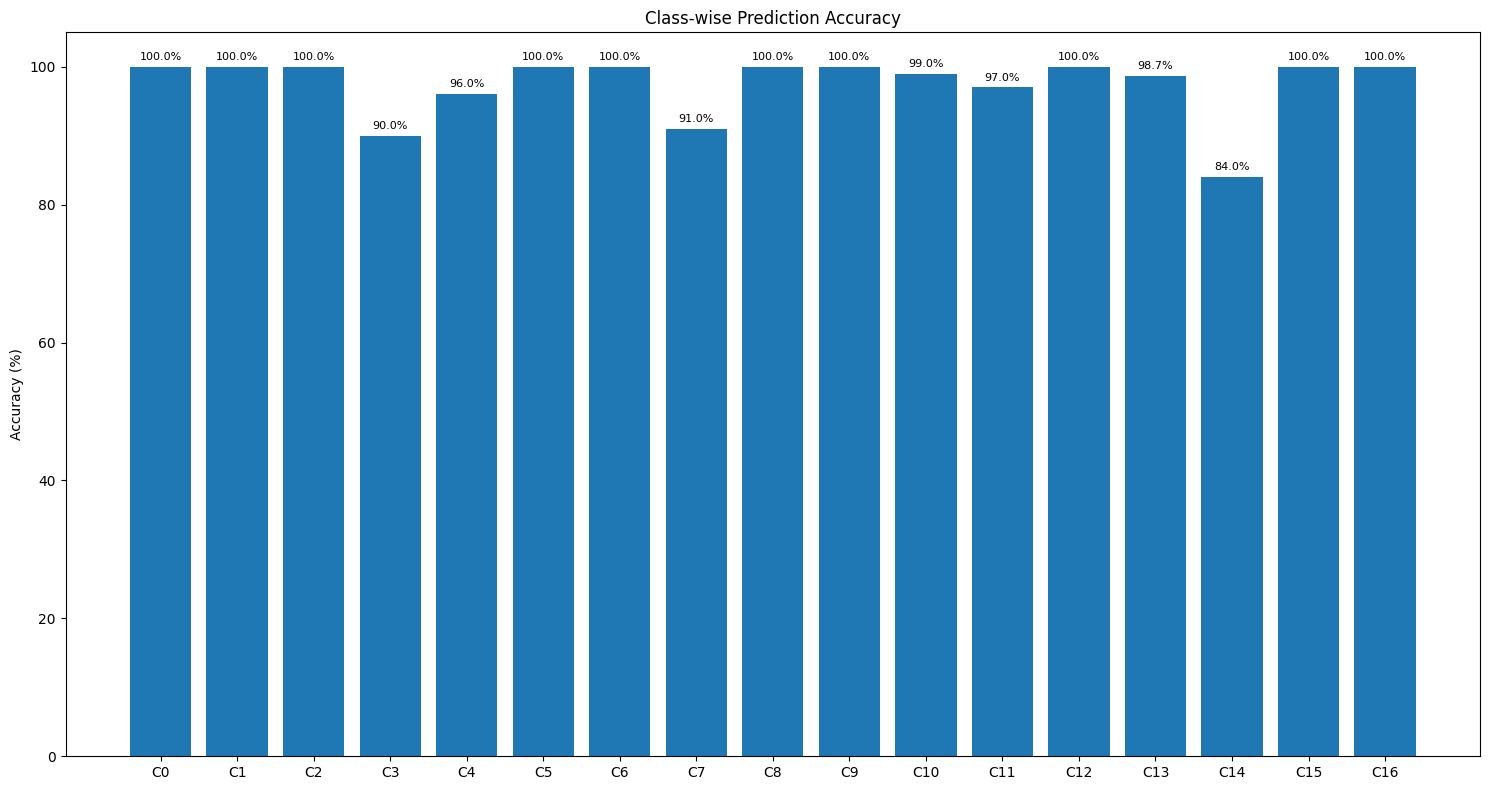

Worst 3 classes:
Class 14: 84.0%
Class 3: 90.0%
Class 7: 91.0%


In [11]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [12]:
# 디렉토리 생성
os.makedirs('models', exist_ok=True)

# fold_models 저장 (현재 메모리에 있다면 바로 실행 가능)
print("Saving fold models...")
for i, state_dict in enumerate(fold_models):
    save_path = f'models/fold_{i+1}_best.pth'
    torch.save(state_dict, save_path)  # 그냥 직접 저장
    print(f"✓ Fold {i+1} model saved to {save_path}")

print(f"All {len(fold_models)} fold models saved!")

Saving fold models...
✓ Fold 1 model saved to models/fold_1_best.pth
✓ Fold 2 model saved to models/fold_2_best.pth
✓ Fold 3 model saved to models/fold_3_best.pth
✓ Fold 4 model saved to models/fold_4_best.pth
✓ Fold 5 model saved to models/fold_5_best.pth
All 5 fold models saved!


In [ ]:
# save_models()

NameError: name 'save_models' is not defined

In [15]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [17]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [18]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [19]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=16,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [20]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [21]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 197/197 [33:06<00:00, 10.08s/it]


In [22]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [23]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [24]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [ ]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


In [1]:
# =============================================================================
# 📊 K-Fold 결과 분석 (단일 모델 버전)
# =============================================================================

print(f"\n{'='*60}")
print("🏁 K-FOLD 결과 상세 분석")
print(f"{'='*60}")

# 전체 성능 요약
val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

print(f"\n🤖 모델: {model_name}")
print(f"📊 평균 CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"🏆 최고 Fold: {max(val_f1_scores):.4f}")
print(f"📉 최악 Fold: {min(val_f1_scores):.4f}")
print(f"📏 성능 범위: {max(val_f1_scores) - min(val_f1_scores):.4f}")

# Fold별 상세 성능
print(f"\n📋 Fold별 상세 결과:")
print(f"{'📁 Fold':<8} {'🎯 Val F1':<10} {'📈 Train F1':<11} {'👥 Train':<8} {'✅ Val':<7}")
print("─" * 50)

for result in fold_results:
   print(f"   {result['fold']:<5} "
         f"   {result['best_val_f1']:<8.4f} "
         f"   {result['final_train_f1']:<9.4f} "
         f"   {result['train_samples']:<6} "
         f"   {result['val_samples']:<5}")

# 성능 순위
sorted_results = sorted(fold_results, key=lambda x: x['best_val_f1'], reverse=True)
print(f"\n🏅 성능 순위:")
medals = ["🥇", "🥈", "🥉", "🏅", "🏅"]
for i, result in enumerate(sorted_results):
   medal = medals[i] if i < len(medals) else "📍"
   print(f"{medal} {i+1}위: Fold {result['fold']} - F1: {result['best_val_f1']:.4f}")

# 클래스별 성능 분석
if fold_class_accuracies:
   print(f"\n🎯 클래스별 성능 분석:")
   print(f"{'📊 Class':<9} {'📈 평균':<8} {'📏 표준편차':<9} {'🏆 최고':<7} {'📉 최악':<7}")
   print("─" * 45)
   
   class_performance = []
   for class_id in range(17):
       class_accs = []
       for fold_acc in fold_class_accuracies:
           if class_id in fold_acc:
               class_accs.append(fold_acc[class_id])
       
       if class_accs:
           mean_acc = np.mean(class_accs)
           std_acc = np.std(class_accs)
           max_acc = max(class_accs)
           min_acc = min(class_accs)
           
           class_performance.append({
               'class_id': class_id,
               'mean_acc': mean_acc,
               'std_acc': std_acc,
               'max_acc': max_acc,
               'min_acc': min_acc
           })
           
           print(f"   {class_id:<5} "
                 f"   {mean_acc:<6.3f} "
                 f"   {std_acc:<7.3f} "
                 f"   {max_acc:<5.3f} "
                 f"   {min_acc:<5.3f}")
   
   # 어려운 클래스 TOP 3
   worst_classes = sorted(class_performance, key=lambda x: x['mean_acc'])[:3]
   print(f"\n🔴 가장 어려운 클래스 TOP 3:")
   for i, cls in enumerate(worst_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")
   
   # 쉬운 클래스 TOP 3
   best_classes = sorted(class_performance, key=lambda x: x['mean_acc'], reverse=True)[:3]
   print(f"\n🟢 가장 쉬운 클래스 TOP 3:")
   for i, cls in enumerate(best_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")

# 성능 일관성 분석
cv_coefficient = std_f1 / mean_f1 if mean_f1 > 0 else 0
print(f"\n⚖️ 성능 일관성 분석:")
print(f"📊 변동계수 (CV): {cv_coefficient:.3f}")

if cv_coefficient < 0.05:
   consistency_emoji = "🟢"
   consistency_text = "매우 일관적인 성능"
elif cv_coefficient < 0.1:
   consistency_emoji = "🔵"
   consistency_text = "일관적인 성능"
elif cv_coefficient < 0.15:
   consistency_emoji = "🟡"
   consistency_text = "보통 수준의 일관성"
else:
   consistency_emoji = "🔴"
   consistency_text = "성능 변동이 큼"

print(f"{consistency_emoji} {consistency_text}")

# 추가 통계
overfit_count = sum(1 for result in fold_results 
                  if result['final_train_f1'] - result['best_val_f1'] > 0.05)

print(f"\n📈 학습 상태 분석:")
print(f"🎯 과적합 의심 Fold: {overfit_count}/{len(fold_results)}개")
if overfit_count > 0:
   print(f"   💡 Train-Val F1 차이가 0.05 이상인 fold 수")

print(f"\n✅ 학습 완료! 총 {len(fold_results)}개 fold 모델 저장됨")
print(f"📁 저장된 모델 파일:")
for i, result in enumerate(fold_results, 1):
   print(f"   📄 {result['model_path']}")

print(f"\n🎉 K-Fold Cross Validation 분석 완료!")


🏁 K-FOLD 결과 상세 분석


NameError: name 'fold_results' is not defined